# Amazon Reviews for SA fine-grained 5 clases CSV


In [4]:
import seaborn as sb
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import re
import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from textblob import TextBlob
from tqdm import tqdm

pd.options.mode.chained_assignment = None
from wordcloud import WordCloud

plt.rcParams.update(plt.rcParamsDefault)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Dataset


In [5]:
train_df = pd.read_csv('../docs/train.csv').dropna()
test_df = pd.read_csv('../docs/test.csv').dropna()

In [6]:
# Shorten the number of samples from every class_index type (n = 200000)

classes = []
n_samples = 3000

for i in range(1, 6):
    classes.append(train_df.query(f'class_index == {i}').sample(n=n_samples))

train_df_s = pd.concat(classes)
train_df_s.reset_index(drop=True, inplace=True)


train_df_s['review_full']= train_df_s['review_title'] + ' ' + train_df_s['review_text']



## Exploratory analysis


word distribution per class based on TF-IDF, and so on

In [7]:
# checking for presence of null values that might interfere with data processing
train_df.isna().sum()

class_index     0
review_title    0
review_text     0
dtype: int64

In [8]:
sb.countplot(x='class_index', data=train_df_s)
plt.title('Rating Distribution')


Text(0.5, 1.0, 'Rating Distribution')

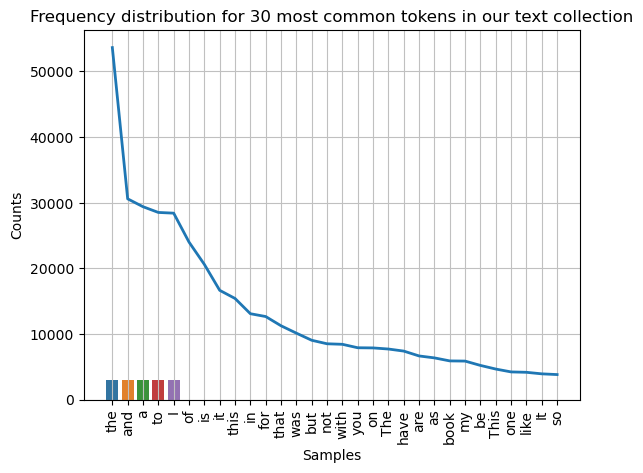

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection'}, xlabel='Samples', ylabel='Counts'>

In [9]:
c = " ".join([w for w in train_df_s['review_full']])

fdist_filtered = FreqDist([ w for w in c.split()])
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection')


In [10]:
def sentiment_analysis(string):
    sentences = TextBlob(string).sentences
    sentiments = [s.sentiment.polarity for s in sentences]
    return sum(sentiments)/len(sentiments)

In [11]:
train_df_s['sentiment'] = train_df_s['review_title'] 
train_df_s['weight'] = train_df_s['review_title'] 

for i, review_full in enumerate(train_df_s['review_full']):
    sentiment = sentiment_analysis(review_full)
    train_df_s['sentiment'][i] = sentiment
    #train_df_s['weight'][i] = 1 - abs(((sentiment + 1) / 2) - (train_df_s['class_index'][i] / 5))

sb.barplot(data=train_df_s, x='class_index', y='sentiment')

<AxesSubplot:xlabel='class_index', ylabel='sentiment'>

## Preprocess data


In [12]:
stop_words = list(nltk.corpus.stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')
stop_words.extend(['book','movie','product','one','time','cd','dvd'])

words = list(nltk.corpus.words.words())
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def handle_negation(string_array):
    string = ''
    i = 0
    while(i < (len(string_array) - 1)):
      if (string_array[i] == 'not'):
        string = string + ' ' + 'NOT_' + string_array[i + 1] 
        i += 1
      else:
        string = string + ' ' + string_array[i]
      i += 1
    return string

def preprocess_data(string):
    string = string.lower()
    text_contractions = [contractions.fix(w) for w in string.split()]
    string = re.sub("[^a-zA-Z]", " ", " ".join(text_contractions))
    string_list = word_tokenize(string)
    text_stems = [stemmer.stem(w) for w in string_list if w not in stop_words]
    return handle_negation(text_stems)

In [13]:
for i, review_full in tqdm(enumerate(train_df_s['review_full'])):
    preprocess_text = preprocess_data(review_full)
    train_df_s['review_full'][i] = preprocess_text

train_df_s.head()

15000it [00:19, 750.08it/s]


,class_index,review_title,review_text,review_full,sentiment,weight
0,1,the tool is worthless,I bought this tool in june 2010 and I could no...,tool worthless bought tool june could NOT_use...,-0.11,the tool is worthless
1,1,Good in a pinch,Happy with this product. We had to make emerge...,good pinch happi make emerg repair gxlxthp dr...,0.0925,Good in a pinch
2,1,Buy the B60 instead,We bought this as an upgrade since it has more...,buy b instead bought upgrad sinc choic brew s...,0.1625,Buy the B60 instead
3,1,Pile of antiquated junk,I upgraded from 2005 for only 3 reasons.1) I w...,pile antiqu junk upgrad reason want univers b...,0.059428,Pile of antiquated junk
4,1,If you thought that this was Dj SASHA you got ...,To any one who was on line and thought that th...,thought dj sasha got hose line thought new dj...,-0.012727,If you thought that this was Dj SASHA you got ...


In [14]:
train_df_s

,class_index,review_title,review_text,review_full,sentiment,weight
0,1,the tool is worthless,I bought this tool in june 2010 and I could no...,tool worthless bought tool june could NOT_use...,-0.11,the tool is worthless
1,1,Good in a pinch,Happy with this product. We had to make emerge...,good pinch happi make emerg repair gxlxthp dr...,0.0925,Good in a pinch
2,1,Buy the B60 instead,We bought this as an upgrade since it has more...,buy b instead bought upgrad sinc choic brew s...,0.1625,Buy the B60 instead
3,1,Pile of antiquated junk,I upgraded from 2005 for only 3 reasons.1) I w...,pile antiqu junk upgrad reason want univers b...,0.059428,Pile of antiquated junk
4,1,If you thought that this was Dj SASHA you got ...,To any one who was on line and thought that th...,thought dj sasha got hose line thought new dj...,-0.012727,If you thought that this was Dj SASHA you got ...
...,...,...,...,...,...,...
14995,5,ultimate doo wop collection box set,fantastic is all i can say hard to find songs ...,ultim doo wop collect box set fantast say har...,0.255625,ultimate doo wop collection box set
14996,5,The Gold Standard for Sound Reinforcement,If you are doing any sort of sound reinforceme...,gold standard sound reinforc sort sound reinf...,0.575,The Gold Standard for Sound Reinforcement
14997,5,A summary,Dean's book pulls together all I'v previously ...,summari dean pull togeth v previous read expe...,0.355556,A summary
14998,5,Love it,I bought this machine at Comp USA on sale for ...,love bought machin comp usa sale cheap toss g...,0.16375,Love it


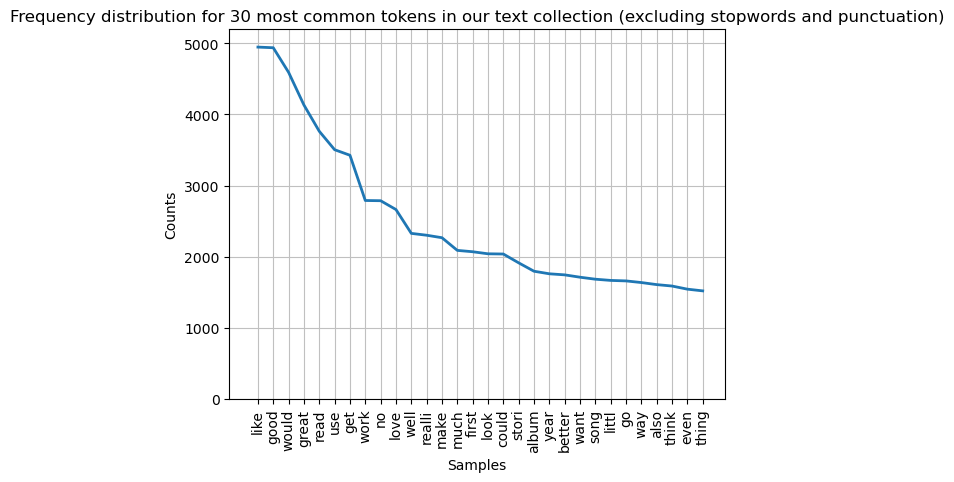

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)'}, xlabel='Samples', ylabel='Counts'>

In [15]:
c = " ".join([w for w in train_df_s['review_full']])

fdist_filtered = FreqDist([ w for w in c.split()])
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')


## Machine Learning

### Train test split

In [16]:
corpus = train_df_s['review_full']

vectorizer = CountVectorizer()
tfidf = TfidfTransformer()

X = Pipeline([
    ('count_vectorizer', vectorizer),
    ('tfidf_transformer', tfidf)
]).fit_transform(corpus)

y = train_df_s['class_index']

# 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



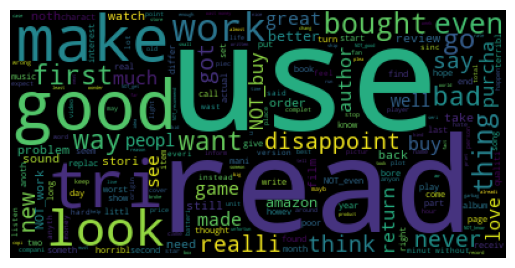

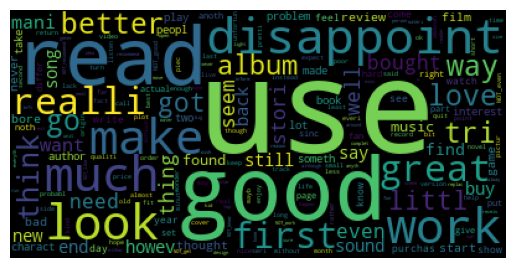

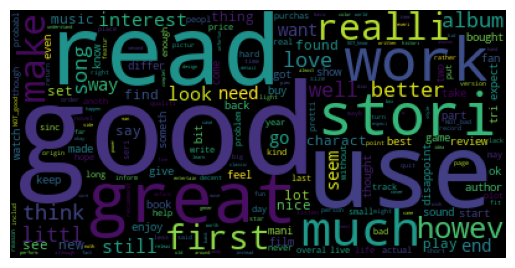

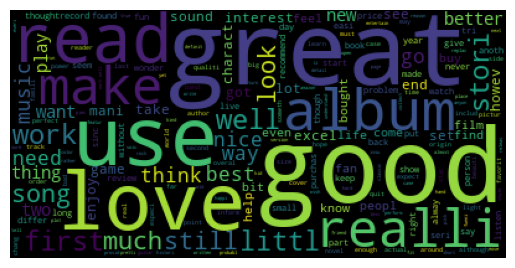

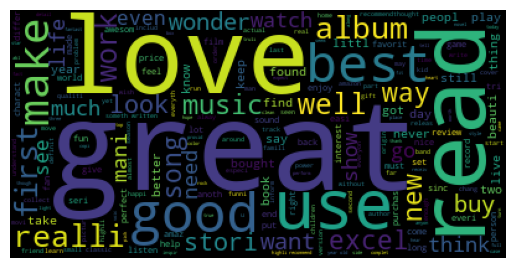

In [17]:
for i in range(1,6):
  wordcloud = WordCloud().generate(" ".join(corpus[j] for j in range(0, len(corpus)) if train_df_s['class_index'][j] == i ))
  plt.figure()
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

### Test split

In [18]:
n_samples = 20000

test_df_s = test_df.sample(n=n_samples)
test_df_s.reset_index(drop=True, inplace=True)

test_df_s['review_full']= test_df_s['review_title'] + ' ' + test_df_s['review_text']


for i, review_full in tqdm(enumerate(test_df_s['review_full'])):
    preprocess_text = preprocess_data(review_full)
    test_df_s['review_full'][i] = preprocess_text

corpus = test_df_s['review_full']

X_test =  Pipeline([
    ('count_vectorizer', vectorizer),
    ('tfidf_transformer', tfidf)
]).transform(corpus)

y_test = test_df_s['class_index']



20000it [00:28, 701.83it/s]


In [19]:
test_df_s

,class_index,review_title,review_text,review_full
0,4,Interesting Story Line,I Liked this book alot better than the other 4...,interest stori line like alot better book rea...
1,5,Best gift for those who don't celebrate,It's hard times when you have a close friend w...,best gift NOT_celebr hard time close friend w...
2,1,Fans unite for original Star Wars - Remember G...,"Just like everyone else here has stated, I wil...",fan unit origin star war rememb gladiat like ...
3,2,Not Stable,"The 2.0"" Receiver Stabilization Assy' is cheap...",NOT_stabl receiv stabil assi cheap NOT_keep r...
4,3,These are okay...,I bought these bottles based on the other revi...,okay bought bottl base review twin spit lot f...
...,...,...,...,...
19995,4,good,Comfortable ride but still get sore after awhi...,good comfort ride still get sore awhil narrow...
19996,3,Oh well,a southern women having a breakdown. what's ne...,oh well southern women breakdown new life tol...
19997,1,All grown children disappoint by these standards,A whining feel-good book for baby boomers who ...,grown children disappoint standard whine feel...
19998,5,Olivia's best work!,"'Please Don't Keep Me Waiting' is, I feel, Oli...",olivia best work pleas NOT_keep wait feel oli...


### Model and training 


In [33]:
accuracy = []
f1 = []
recall = []
precision = []

algorithms = ['Naive Bayes', 'Decision Tree', 'Neural Networks', 'Suport Vector Machine', 'K-nearest Neighbors', 'Logistic Regression']

def algorithm_analysis(y_pred, y_test):
  accuracy.append(accuracy_score(y_test, y_pred))
  f1.append(f1_score(y_test, y_pred,  average='macro'))
  recall.append(recall_score(y_test, y_pred, average='macro'))
  precision.append(precision_score(y_test, y_pred, average='macro'))

  table_data={
      'Accuracy': accuracy[-1],
      'Precision': precision[-1],
      'F1 score': f1[-1],
      'Recall score': recall[-1]}

  return pd.DataFrame([table_data]).style.hide_index()

#### Naive Bayes


In [34]:
mnb_model = MultinomialNB().fit(X, y)

y_pred = mnb_model.predict(X_test)
confusion_matrix_mnb = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)

Accuracy,Precision,F1 score,Recall score
0.443400,0.443433,0.441568,0.443037


#### Decision Tree


In [35]:
dtc_model = DecisionTreeClassifier().fit(X, y)
y_pred = dtc_model.predict(X_test)

confusion_matrix_dct = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)

Accuracy,Precision,F1 score,Recall score
0.338100,0.337223,0.337237,0.337549


#### Neural Networks


In [36]:
nn_model = MLPClassifier().fit(X, y)
y_pred = nn_model.predict(X_test)

confusion_matrix_nn = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)

Accuracy,Precision,F1 score,Recall score
0.404600,0.405434,0.404727,0.404125


#### Suport Vector Machine

In [37]:
sgdc_model = MLPClassifier().fit(X, y)
y_pred = sgdc_model.predict(X_test)

confusion_matrix_sgdc = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


Accuracy,Precision,F1 score,Recall score
0.405100,0.406029,0.405281,0.404658


#### K Nearest Neighbors

In [38]:
knc_model = KNeighborsClassifier().fit(X, y)
y_pred = knc_model.predict(X_test)

confusion_matrix_knc = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)

Accuracy,Precision,F1 score,Recall score
0.290650,0.288571,0.288392,0.290373


#### Logistic Regression

In [39]:
lr_model = LogisticRegression().fit(X, y)
y_pred = lr_model.predict(X_test)

confusion_matrix_lr = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


/Users/beatrizag__/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy,Precision,F1 score,Recall score
0.474350,0.467965,0.470132,0.473608


# Results

performance on the test set, confusion matrix, precision, recall, accuracy, F1 measure, time spent to train/test the models

At least 3 machine learning algorithms should be employed (Naïve Bayes, Decision Trees, Neural Networks, K-NN, SVM, ...), **matching them with the different ways of generating the dataset**

/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_28150/4231153974.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([0,1,2,3,4,5])
/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_28150/4231153974.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels([0,1,2,3,4,5])


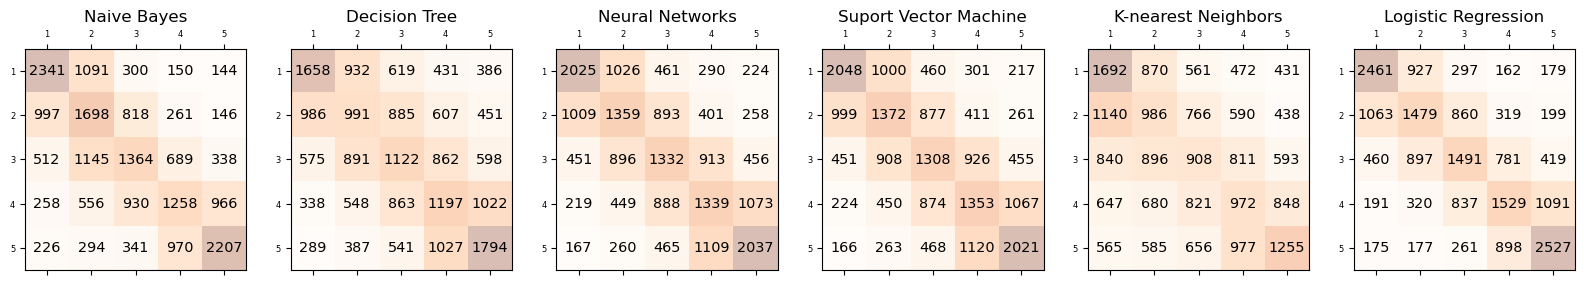

In [44]:
plt.rcParams['font.size'] = '6'

fig, axs = plt.subplots(1, 6, figsize=(20,5))
matrixes = [confusion_matrix_mnb, confusion_matrix_dct, confusion_matrix_nn, confusion_matrix_sgdc, confusion_matrix_knc, confusion_matrix_lr]
for index, ax in enumerate(axs):
  ax.matshow(matrixes[index], cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(matrixes[index].shape[0]):
      for j in range(matrixes[index].shape[1]):
          ax.text(x=j, y=i,s=matrixes[index][i, j], va='center', ha='center', size='xx-large')
  ax.set_title(algorithms[index], fontsize= '12')
  ax.xaxis.set_ticklabels([0,1,2,3,4,5])
  ax.yaxis.set_ticklabels([0,1,2,3,4,5])


plt.show()

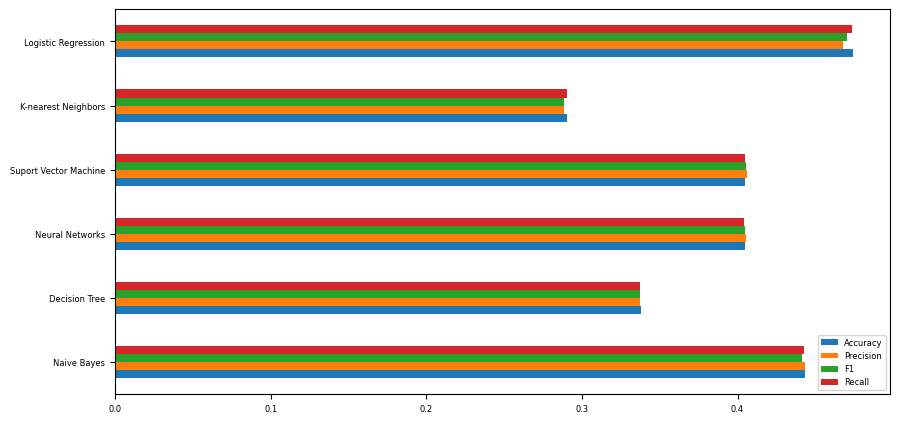

In [54]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams['font.size'] = '6'

data = {
  'Accuracy': accuracy,
  'Precision': precision,
  'F1': f1,
  'Recall': recall,
  }
df = pd.DataFrame(data, algorithms)
ax = df.plot.barh()
plt.show()
